In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
import pickle
import numpy as np
import time
import itertools
from tqdm.notebook import tqdm
import matplotlib.cm as cm

/home/datahog/venvs/py_36/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
!pip install python-louvain


In [3]:
import community as community_louvain


In [4]:
df = pd.read_csv('../data/soc-redditHyperlinks-body.tsv',sep='\t')

In [5]:
nodes = df['SOURCE_SUBREDDIT'].unique().tolist()
nodes.extend(df['TARGET_SUBREDDIT'].unique().tolist())

## Create directed graph 

In [6]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(list(zip(df['SOURCE_SUBREDDIT'].values.tolist(),
                          df['TARGET_SUBREDDIT'].values.tolist())))

Louvain-Algorithm needs graph to be fully connected, using `nx.connected_components` we're getting all connected components. The first subgraph is the biggest, in our case encompassing about 99% of all nodes

In [7]:
# Louvain need the graph to be fully connected ... with this method we'
comps = list(nx.connected_components(G))
connected_subgrpah = G.subgraph(comps[0])
nx.is_connected(connected_subgrpah)


True

In [ ]:
partition = community_louvain.best_partition(connected_subgrpah,random_state=42,)

After creating the partitions, build up the appropriate structures to use these partitions. In our case always grouping communities of highly interconnected nodes

In [ ]:
df_part = pd.DataFrame(partition.items(),columns=['subreddit','partition'])
part_dict = dict(partition)
df_part.head()

In [ ]:
df_cropped = df[((df['SOURCE_SUBREDDIT'].isin(comps[0])) | (df['TARGET_SUBREDDIT'].isin(comps[0])))]

Create new Graph from then partition df, this part basically reduces our 34k unique nodes to ~ 60 nodes

In [ ]:
comms_G = nx.Graph()
comms_G.add_nodes_from(df_part.partition.unique())


In [ ]:
edges = list(
    zip(df_cropped['SOURCE_SUBREDDIT'].apply(part_dict.get).values.tolist(),
         df_cropped['TARGET_SUBREDDIT'].apply(part_dict.get).values.tolist()))


In [ ]:
df_cropped['source_enc'] = df_cropped['SOURCE_SUBREDDIT'].apply(part_dict.get).values
df_cropped['target_enc'] = df_cropped['TARGET_SUBREDDIT'].apply(part_dict.get).values


Calculate the weight for each of the edges, needs to be bidirectional i.e. from source to target and from target to source

In [ ]:
source_weight = df_cropped.groupby(['source_enc','target_enc'])['LINK_SENTIMENT'].mean().to_dict()


In [ ]:
target_weight = df_cropped.groupby(['target_enc','source_enc'])['LINK_SENTIMENT'].mean().to_dict()

Caclulate most occuring subreddit in sub network, basically each node is labeled by the most occuring subreddit in the (Network)community

In [ ]:
sample_label = dict()

for i in range(df_part['partition'].max()):
    part_data = df_cropped[(df_cropped['target_enc'] == i) | (df_cropped['target_enc'] == i)]
    part_subreddits = part_data['SOURCE_SUBREDDIT'].values.tolist()
    part_subreddits.extend(part_data['TARGET_SUBREDDIT'].values)
    sr = pd.Series(part_subreddits).value_counts().index[0]

    sample_label[i] = sr

Set Weights in Network with precalculated weights 

In [ ]:
comb_dict = source_weight
comb_dict.update(target_weight)

In [ ]:
for k,v in comb_dict.items():
    comms_G.add_edge(k[0],k[1],weight=v)

In [ ]:
comms_G = nx.relabel_nodes(comms_G, sample_label)

In [ ]:
cmap2 = cm.get_cmap('RdYlGn', max(comb_dict.values()) + 1)

In [ ]:
edges,weights = list(zip(*nx.get_edge_attributes(comms_G,'weight').items()))

In [ ]:
# Some trickery to make positive edges less thin than negative edges for better visibility
widths = [x/2 if x > 0 else x*2 for x in weights]

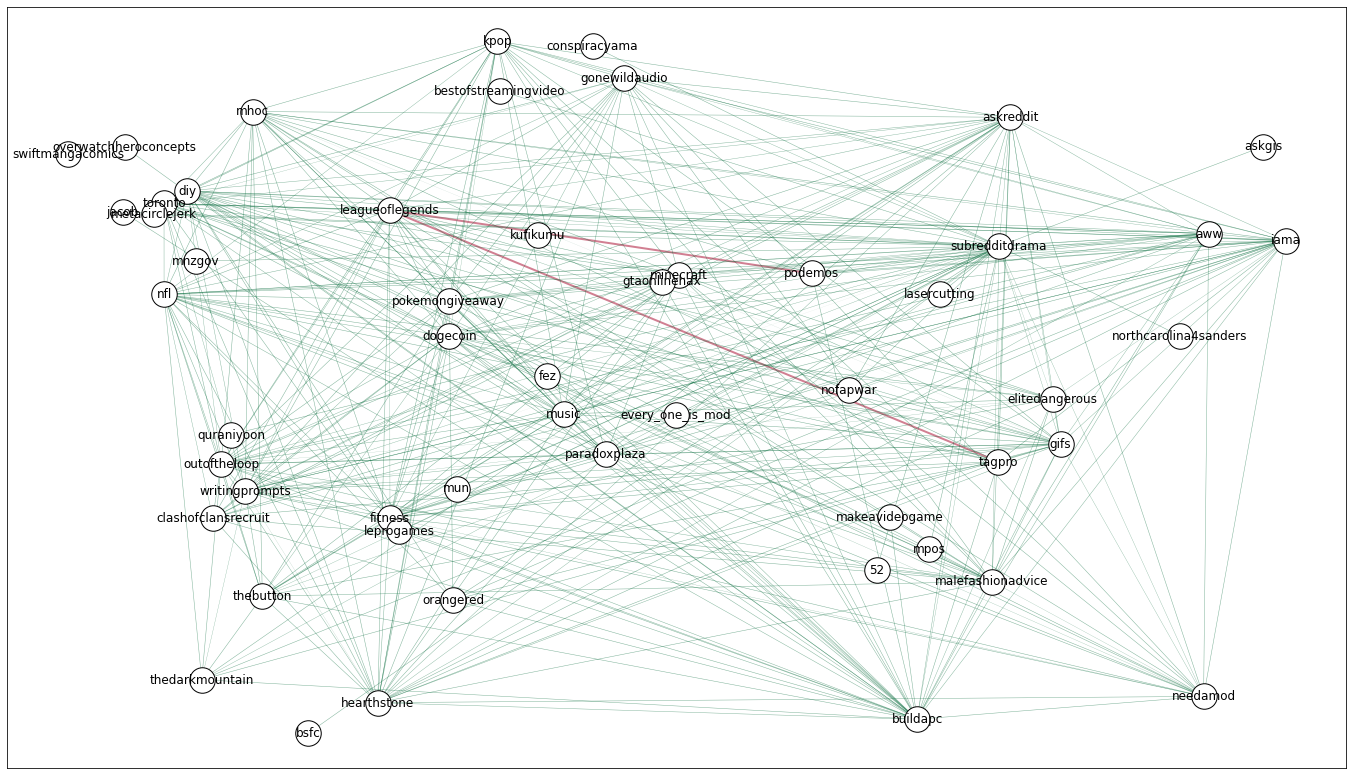

In [28]:

fig = plt.figure(figsize=(24,14))
#pos = nx.spring_layout(comms_G,iterations=45,threshold=0.1)
#pos = nx.circular_layout(comms_G)
pos = nx.random_layout(comms_G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(comms_G, pos,edgecolors='black',
                       node_size=650,
                       cmap=cmap, node_color='white')
nx.draw_networkx_labels(comms_G,pos)
nx.draw_networkx_edges(comms_G, pos,edge_color=widths,
                       edge_cmap=cmap2,width=widths,
                       alpha=0.5)